# JRC Basic

### no preprocessing, with all labels

## Data Fetching and Preparation


In [27]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN='../reuters_data/converted_filtered.csv'
bs = 32

**Get the dataset**





In [2]:
df = pd.read_csv(FN)

## keep only text and labels
df = df[['text','labels']]
print(len(df))
df.tail()



11367


,text,labels
11362,U.K. INTERVENTION BOARD DETAILS EC SUGAR SALES...,88
11363,MEAD <MEA> EXPECTS IMPROVED EARNINGS THIS YEAR...,35
11364,"AMERTEK INC <ATEKF> 1ST QTR NET WOODSTOCK, Ont...",35
11365,ALEX BROWN INC <ABSB> 1ST QTR MARCH 27 NET BAL...,35
11366,TOWN AND COUNTRY JEWELRY MANUFACTURING <TCJC> ...,35


## Fine-tuning of the language model

In [4]:
data_lm = (TextList.from_csv(Path('.'), FN, cols='text') #, max_vocab=100000, min_freq=2)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('Reuters_basic_data_lm.pkl')
print('done')

done


In [5]:
data_lm = load_data(Path('.'), 'Reuters_basic_data_lm.pkl', bs=bs)

In [6]:
data_lm.show_batch()

idx,text
0,"mln dlrs in the 26 weeks ended xxmaj december 28 from xxunk mln a year earlier although pre - tax profit rose 9.1 pct to xxunk mln from xxunk mln . xxmaj net would have risen 10.1 pct but for the increase in company tax to 49 pct from 46 and the imposition of the tax on fringe benefits , paid by employers and not the xxunk , the company"
1,"triggered by the strong yen . xxmaj officials said there are already signs of that . xxmaj more and more companies have announced plans to move production facilities offshore to take advantage of cheaper costs abroad , they said . xxup reuter xxbos xxup geodome < xxup xxunk > xxup to xxup start xxup mine xxup construction xxup hailey , xxmaj idaho , xxmaj march 20 - xxmaj geodome xxmaj"
2,"'s budget proposals for 1988 - 1992 would cut farm program spending an additional 24 billion dlrs . xxmaj in 1987 , foreign economic growth is expected to remain close to 2.6 pct , the same as in 1986 , but above the 2.4 pct average of 1980 - 86 , it said . xxmaj partially because of this improvement , xxup u.s. export volume is expected to rise in"
3,"retain operating links with their xxup u.s. delivery network , generating traffic for the former parent companies without them having to tie up capital in xxmaj canada . xxmaj the nature of the business is that incremental traffic is incremental revenue , xxmaj hine said . xxmaj it 's sort of a sausage maker business where you put in place the sausage xxunk , and the more sausage you can"
4,"very vital waterway of the world , he said on xxup nbc television 's xxmaj meet the xxmaj press . xxmaj the xxmaj state xxmaj department said xxmaj friday xxmaj iran has been informed about xxup u.s. concern over the threat to oil shipments in the xxmaj gulf . xxmaj the xxunk was sent through xxmaj switzerland , which represents xxmaj american interests in xxmaj iran . xxmaj iran on"


In [7]:
# download pre-trained (Wikipedia) model and create learner
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

In [8]:
# test wikidata lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The European Commission on Political Affairs , Part 2 of the European Convention on the Rights of Persons , August 12 , 2001 , by the European Commission on Civil Rights
The European Commission on International Affairs , KLM , by Robert Brown , ICC , in January . The report stated that Heinrich Brown was the meeting 's director of technical research ,
The European Commission on International Cooperation in Europe , August 1995 and December 1993 in the US , Great Britain and France , USA and the United States , Canada
The European Commission on International Law ( UN ) introduced the International Trade Commission Act , Anglo - American International Law Commission ( UN ) , on 12 July


In [9]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


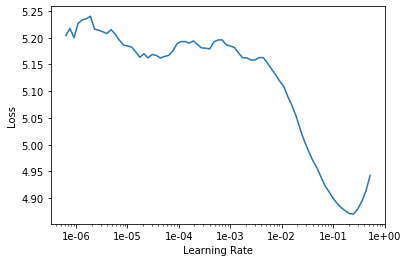

In [10]:
learn_lm.recorder.plot(skip_end=15)

In [11]:
learn_lm.fit_one_cycle(2, 7e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.048079,3.021713,0.485714,00:48
1,3.282450,1.832164,0.614286,00:48


In [12]:
learn=learn_lm
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


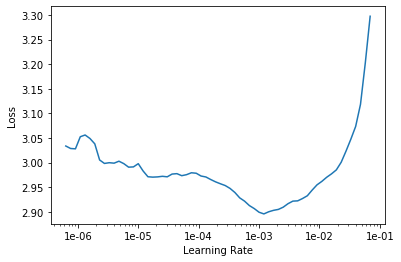

In [13]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [14]:
epochs = 5 # orig: 10
learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4), 1e-3) , moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.859962,1.720679,0.685714,01:01
1,2.769725,1.653447,0.714286,01:01
2,2.621275,1.625703,0.742857,01:02
3,2.547477,1.628361,0.742857,01:02
4,2.426707,1.618090,0.757143,01:02


In [15]:
learn.save('fine_tuned-Reuters-basic')
learn.load('fine_tuned-Reuters-basic')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (10231 items)
x: LMTextList
xxbos xxup fairfax xxup says xxup higher xxup tax xxup hits xxup first xxup half xxup earnings xxup sydney , xxmaj march 19 - xxmaj media group xxmaj john xxmaj fairfax xxmaj ltd < xxup xxunk > said that its flat first half net profit partly reflected the impact of changes in the xxmaj australian tax system . xxmaj fairfax earlier reported net earnings edged up 2.3 pct to 25.94 mln dlrs in the 26 weeks ended xxmaj december 28 from xxunk mln a year earlier although pre - tax profit rose 9.1 pct to xxunk mln from xxunk mln . xxmaj net would have risen 10.1 pct but for the increase in company tax to 49 pct from 46 and the imposition of the tax on fringe benefits , paid by employers and not the xxunk , the company said in a statement . xxmaj fairfax also pointed to the cyclical downturn in revenue growth in the television industry as another reason for the flat first half earnings . xxmaj it said it conside

In [16]:
# test lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 5
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


The European Commission AGREES TO BUY EC SUGAR MARKET BRUSSELS , March 19 - The European Community Commission ( EC ) has approved a tender in the EC for
The European Commission APPROVES EC COMMISSION BRUSSELS , March 11 - The EC Commission has approved the European Community Commission ( EC ) this year to allow the EC to
The European Commission APPROVES EC OILS TAX BRUSSELS , April 13 - The EC Commission has accepted a proposal for 1987 tax cuts on vegetable oils and fats , but EC diplomats said
The European Commission BUYS VAN ARNHEM , IN EC LONDON , March 12 - The U.S. And West African States have purchased the world 's largest foreign exchange , <
The European Commission HAS NO PLANS TO CUT PRIME RATES FRANKFURT , April 7 - British Prime Minister Margaret Thatcher said he would not comment on the bank 's


In [17]:
learn.save_encoder('fine_tuned_enc-Reuters-basic')


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [18]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [19]:
## make small subsample in order to train faster
df = pd.read_csv(FN)
df = df[['text','labels']]


In [40]:

df = df[pd.notnull(df['labels'])]
len(df)
df.to_csv('a.csv')


In [41]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas-basic.pkl')

In [42]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

18248
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'the', ',', '.', 'of', 'to', 'in', 'and', 'said', 'a', '-', 'mln']


In [43]:
data_clas = load_data(Path('.'), 'data_clas-basic.pkl', bs=bs)

In [44]:
data_clas.show_batch()
#data_clas.label_list


text,target
"xxbos xxup u.s. xxup supply / xxup demand xxup detailed xxup by xxup usda xxmaj washington , xxmaj april 9 - xxmaj the xxup u.s. xxmaj agriculture xxmaj department made the following supply / demand projections for the 1986 / 87 seasons , in mln bushels , with comparisons , unless noted -- xxup corn -- 1986 / 87 1985 / 86 04 / 09 / 87 03 / 09",103;109;112;113;118;19;42;45;56;59;67;68;81;98
"xxbos xxup talking xxup point / xxup borg - xxup warner xxup corp < xxup bor > xxmaj by xxmaj patti xxmaj domm , xxmaj reuters xxmaj new xxmaj york , xxmaj march 31 - xxmaj borg - xxmaj warner xxmaj corp will vigorously resist xxup gaf xxmaj corp 's xxunk - per - share takeover offer , but the xxmaj midwest conglomerate may fall prey to another offer ,",77
"xxbos xxup illinois xxup co - xxup op xxup futures xxup dissolution xxup vote xxup set xxmaj by xxmaj keith xxmaj xxunk xxup chicago , xxmaj march 24 - xxmaj the shareholders of xxmaj illinois xxmaj cooperative xxmaj futures xxmaj co. , the futures trading arm of many xxmaj midwest farm cooperatives for more than 25 years , will vote xxmaj wednesday on its possible dissolution . xxmaj the directors",59
"xxbos xxup economic xxup spotlight - xxup polish xxup sanctions xxmaj by xxmaj xxunk xxmaj xxunk , xxmaj reuters xxup warsaw , xxmaj march 5 - xxmaj poland says xxup u.s. xxmaj sanctions have cost its economy 15 billion dlrs and has made clear it wants xxmaj washington to take a lead in repairing the damage after lifting remaining restrictions two weeks ago . xxmaj polish officials are unable to",117
"xxbos xxup u.s. xxup may xxup have xxup to xxup act xxup to xxup support xxup dollar xxup by xxup peter xxup torday , xxup reuters xxup washington , xxmaj april 29 - xxmaj the prospect of renewed assaults on the dollar might force the xxmaj united xxmaj states eventually to unveil xxunk measures to bolster support for its currency , monetary analysts and economists said . xxmaj treasury xxmaj",2;74


In [45]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-Reuters-basic')


In [46]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


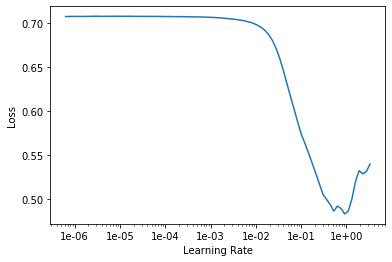

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(2, slice(2e-2,2e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.037397,0.030284,0.991611,0.575922,0.672944,0.488792,0.055279,0.889794,0.674194,0.488389,0.191539,0.967227,0.682910,0.487390,0.412890,0.979631,0.692514,0.484515,0.506344,0.986054,0.708374,0.478800,0.542485,0.988886,0.726233,0.474816,0.552678,0.990590,0.741064,0.468084,0.549876,0.991611,0.762793,0.464588,0.544009,00:25
1,0.023061,0.015433,0.995355,0.716276,0.885532,0.687236,0.090114,0.938732,0.886083,0.685543,0.444654,0.982120,0.889072,0.679740,0.682352,0.989520,0.894257,0.672795,0.750134,0.993616,0.903077,0.660401,0.787588,0.994922,0.909539,0.648730,0.784376,0.995270,0.914502,0.636048,0.760499,0.995355,0.922020,0.625236,0.734593,00:26


In [50]:
learn.save('first-basic')

In [51]:
learn.load('first-basic')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9081 items)
x: TextList
xxbos xxup britoil xxup plc < xxup xxunk > 1986 xxup yr xxup london , xxmaj march 19 - xxmaj shr xxunk vs xxunk xxmaj final div 6p , making xxunk vs 13p . xxmaj pre - tax profit 134 mln stg vs 759 mln . xxmaj net profit 33 mln vs 253 mln . xxmaj turnover 978 mln stg vs 1.80 billion . xxmaj extraordinary debit 50 mln vs nil . xxmaj operating profit 149 mln stg vs 756 mln . xxmaj exceptional debit on rationalisation programme 12 mln vs nil xxmaj petroleum xxmaj revenue xxmaj taxes 77 mln vs 319 mln , xxup u.k. xxmaj corporation tax and overseas tax 24 mln vs 187 mln , xxmaj note - xxmaj the net effect of accounting changes in 1986 was to reduce after tax profits by 47 mln stg . xxmaj retained earnings for prior years were increased by 209 mln . xxmaj extraordinary debit of 50 mln stg related to the decision to seek a buyer for the company 's xxup u.s. xxmaj assets . xxup reuter,xxbos ( xxup xxunk xxup for xxup 

Why gradual unfreeze? Give example of Image detection.

In [52]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


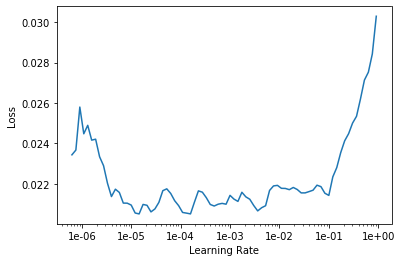

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(4, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.020105,0.014669,0.995529,0.748072,0.875212,0.714726,0.111000,0.941746,0.875927,0.713759,0.490048,0.981359,0.881445,0.710067,0.683162,0.989362,0.885688,0.705668,0.753553,0.993690,0.896131,0.692880,0.799660,0.994899,0.907415,0.681919,0.799177,0.995336,0.912441,0.670211,0.783431,0.995529,0.919904,0.658930,0.762642,00:33
1,0.018207,0.013722,0.995822,0.778209,0.886946,0.734279,0.120335,0.949366,0.888194,0.733615,0.503874,0.984268,0.892191,0.731272,0.715546,0.990818,0.893438,0.724669,0.779280,0.994161,0.899043,0.713260,0.808124,0.995251,0.903497,0.703833,0.810715,0.995749,0.912545,0.691668,0.803016,0.995822,0.919306,0.681741,0.784093,00:31
2,0.016774,0.012915,0.995970,0.793786,0.882627,0.752942,0.135917,0.955464,0.883547,0.752003,0.566504,0.985331,0.887418,0.749260,0.740066,0.991359,0.890361,0.746047,0.797588,0.994300,0.897567,0.738759,0.820926,0.995367,0.902017,0.730748,0.823299,0.995799,0.906663,0.720829,0.813850,0.995970,0.912255,0.713877,0.794610,00:33
3,0.016102,0.012785,0.995993,0.798651,0.885495,0.752559,0.143055,0.955360,0.886072,0.751922,0.566415,0.985389,0.889000,0.750039,0.739622,0.991425,0.892118,0.744908,0.797794,0.994416,0.897026,0.738014,0.825505,0.995440,0.903921,0.727119,0.824472,0.995869,0.912302,0.716004,0.817347,0.995993,0.916615,0.706542,0.797279,00:27


In [57]:
learn.save('second-basic')

In [56]:
learn.load('second-basic')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9081 items)
x: TextList
xxbos xxup britoil xxup plc < xxup xxunk > 1986 xxup yr xxup london , xxmaj march 19 - xxmaj shr xxunk vs xxunk xxmaj final div 6p , making xxunk vs 13p . xxmaj pre - tax profit 134 mln stg vs 759 mln . xxmaj net profit 33 mln vs 253 mln . xxmaj turnover 978 mln stg vs 1.80 billion . xxmaj extraordinary debit 50 mln vs nil . xxmaj operating profit 149 mln stg vs 756 mln . xxmaj exceptional debit on rationalisation programme 12 mln vs nil xxmaj petroleum xxmaj revenue xxmaj taxes 77 mln vs 319 mln , xxup u.k. xxmaj corporation tax and overseas tax 24 mln vs 187 mln , xxmaj note - xxmaj the net effect of accounting changes in 1986 was to reduce after tax profits by 47 mln stg . xxmaj retained earnings for prior years were increased by 209 mln . xxmaj extraordinary debit of 50 mln stg related to the decision to seek a buyer for the company 's xxup u.s. xxmaj assets . xxup reuter,xxbos ( xxup xxunk xxup for xxup 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


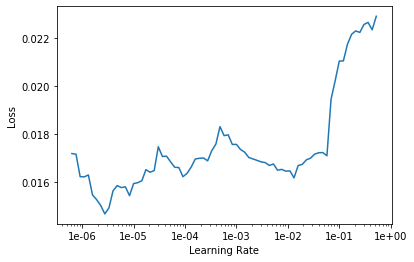

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.017143,0.013728,0.995769,0.831942,0.847947,0.776414,0.162353,0.960434,0.849156,0.775800,0.573864,0.985629,0.852183,0.771063,0.747715,0.990621,0.855773,0.770257,0.793185,0.993566,0.862630,0.762477,0.817013,0.994841,0.868393,0.755898,0.822136,0.995436,0.873341,0.748706,0.817488,0.995769,0.879377,0.741874,0.809804,00:34
1,0.015096,0.011267,0.996383,0.853760,0.890359,0.786931,0.233355,0.964503,0.891064,0.786931,0.623085,0.988079,0.892687,0.784389,0.774873,0.992631,0.894832,0.780509,0.823694,0.995166,0.900803,0.774418,0.850332,0.995954,0.904674,0.766480,0.850318,0.996290,0.909844,0.760053,0.845860,0.996383,0.917269,0.753109,0.831421,00:33


In [61]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


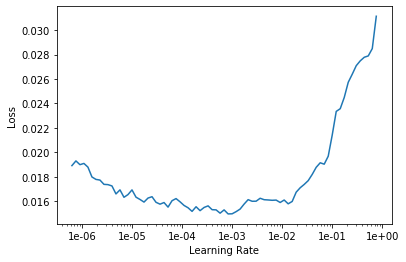

In [62]:
learn.lr_find()
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.014393,0.011049,0.996375,0.855004,0.870739,0.814121,0.205166,0.965430,0.870577,0.813534,0.634251,0.987391,0.872224,0.811999,0.773785,0.992132,0.875857,0.808635,0.823663,0.994891,0.880302,0.802679,0.854015,0.995823,0.888139,0.794561,0.859978,0.996225,0.895200,0.787628,0.857074,0.996375,0.900419,0.781705,0.844632,00:42
1,0.013443,0.010584,0.996565,0.882491,0.884649,0.815412,0.254449,0.971953,0.885547,0.815412,0.664573,0.989667,0.887759,0.814056,0.799067,0.993149,0.892092,0.812102,0.837043,0.995382,0.896831,0.807089,0.861545,0.996132,0.903423,0.802927,0.866167,0.996483,0.906684,0.797306,0.864169,0.996565,0.912489,0.792998,0.851854,00:46
2,0.011672,0.010475,0.996642,0.869024,0.883963,0.823026,0.229039,0.969758,0.885209,0.823026,0.661909,0.988971,0.887438,0.821614,0.797665,0.992812,0.891768,0.818990,0.836099,0.995255,0.898341,0.811359,0.863379,0.996112,0.903876,0.804897,0.869156,0.996503,0.907750,0.798585,0.867202,0.996642,0.912252,0.791564,0.854371,00:48


In [64]:
learn.save('third-basic')

In [65]:
learn.load('third-basic');

In [66]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


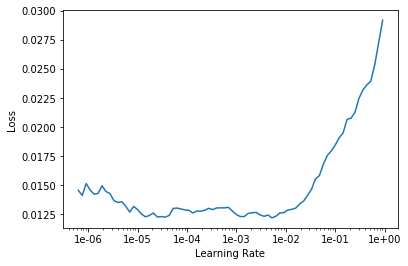

In [67]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.008662,0.008565,0.997558,0.922796,0.928551,0.861630,0.357243,0.982854,0.929208,0.860730,0.759793,0.993508,0.929236,0.858015,0.859968,0.995459,0.931015,0.856723,0.886094,0.996781,0.933417,0.853497,0.904000,0.997253,0.936270,0.847407,0.908195,0.997469,0.939127,0.842343,0.906480,0.997558,0.941589,0.838588,0.901585,01:04
1,0.007344,0.008404,0.997535,0.918425,0.921252,0.867532,0.342265,0.981865,0.921252,0.867532,0.758540,0.992859,0.923800,0.865972,0.853737,0.995119,0.925426,0.864026,0.882246,0.996611,0.929492,0.860586,0.902684,0.997225,0.933423,0.856410,0.908432,0.997446,0.936301,0.849645,0.906610,0.997535,0.939093,0.847157,0.902617,00:51


In [84]:
learn.save('final-basic')

In [85]:
print('done')

done


## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [86]:
y_pred, y_true =  learn.get_preds()

In [87]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [92]:
thresh = 0.42

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.882563551736484
P (micro) 0.8996350364963503
R (micro) 0.8661278988053408

F1 (macro) 0.34949724542586336
P (macro) 0.40028247438787923
R (macro)  0.3338385764172072


In [89]:
f1_score(y_true, y_pred>thresh, average='macro')

0.3536620247948922

In [90]:
y_true_n = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true_n.shape

((2270, 114), (2270, 114))

In [91]:
## precision at k
def tmp_precision(actual, predicted):
    #print(predicted)
    actual_one = np.where(actual == 1)[0]
    #print(actual_one)
    #print(type(actual_one))
    
    act_set = set(list(actual_one))
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def tmp_recall(actual, predicted):
    actual_one = np.where(actual == 1)[0]
    
    act_set = set(actual_one)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

## sort indizes in descending order
scores_idx_sorted = (-scores).argsort() 
    
#print(precs)
for i in range(7):
    k = i+1
    
    precs, recas = [], []
    for i in range(len(y_true_n)):
        precs.append( tmp_precision(y_true_n[i], scores_idx_sorted[i]) )
        recas.append( tmp_recall(y_true_n[i], scores_idx_sorted[i]) )
    
    print("Precision at: %d:   " % (k,), sum(precs)/len(precs))
    print("Recall at: %d:   " % (k,), sum(recas)/len(recas))
    print()

Precision at: 1:    0.9462555066079296
Recall at: 1:    0.8586691490105588

Precision at: 2:    0.55
Recall at: 2:    0.939328019019649

Precision at: 3:    0.38311306901616404
Recall at: 3:    0.9589810153136146

Precision at: 4:    0.2922907488986784
Recall at: 4:    0.966844975875813

Precision at: 5:    0.2377092511013158
Recall at: 5:    0.9748056079994404

Precision at: 6:    0.20000000000000615
Recall at: 6:    0.979106181385917

Precision at: 7:    0.17249842668345552
Recall at: 7:    0.9824248304314381



In [74]:
metrics = classification_report(y_true_n, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
          10       0.60      1.00      0.75         3
         100       0.00      0.00      0.00         0
         101       0.00      0.00      0.00         3
         102       0.00      0.00      0.00         0
         103       0.27      0.43      0.33         7
         104       0.00      0.00      0.00         0
         105       0.00      0.00      0.00         1
         106       0.59      0.83      0.69        12
         107       0.50      1.00      0.67         3
         108       0.33      0.33      0.33         3
         109       0.62      0.57      0.59        14
          11       0.00      0.00      0.00         0
         110       1.00      0.67      0.80         3
         111       0.00      0.00      0.00         0
         112       0.17      0.33      0.22        12
         113       0.38      0.75      0.50        28
         114       0.55    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
